In [7]:
import pandas as pd

# 1. Load the data (make sure these filenames match your folder)
train_chicken_df = pd.read_csv('../data/dog_chicken/train/chicken_features.csv')
train_dog_df = pd.read_csv('../data/dog_chicken/train/dog_features.csv')
test_chicken_df = pd.read_csv('../data/dog_chicken/test/chicken_features.csv')
test_dog_df = pd.read_csv('../data/dog_chicken/test/dog_features.csv')

# 2. Assign clear, integer targets
train_chicken_df['target'] = 0
train_dog_df['target'] = 1
test_chicken_df['target'] = 0
test_dog_df['target'] = 1

# 3. Combine them
train_df = pd.concat([train_chicken_df, train_dog_df], axis=0).reset_index(drop=True)
test_df = pd.concat([test_chicken_df, test_dog_df], axis=0).reset_index(drop=True)

# 4. Verification Step
print("Verification - Target column counts:")
print(f"Train: {train_df['target'].value_counts()}\nTest: {test_df['target'].value_counts()}")


Verification - Target column counts:
Train: target
0    500
1    500
Name: count, dtype: int64
Test: target
0    200
1    199
Name: count, dtype: int64


In [9]:
# Create the Feature Matrix (X) by dropping non-visual columns
# We driop 'filenames' and 'mask_sources' (metadata) and 'target' (the answer)

X_train = train_df.drop(columns=['filename', 'mask_source', 'target'])
X_test = test_df.drop(columns=['filename', 'mask_source', 'target'])
X_test = X_test[X_train.columns]

# Create the Target Vector (y)
y_train = train_df['target']
y_test = test_df['target']

print(f"We are training on {X_train.shape[1]} different image traits!")
print("Traits include:", list(X_train.columns[:5]), "...")

We are training on 15 different image traits!
Traits include: ['mean_r', 'mean_g', 'mean_b', 'glcm_contrast', 'glcm_homogeneity'] ...


In [10]:
from sklearn.ensemble import RandomForestClassifier

# 1. Initialize the model
# n_estimators=100 means the 'forest' is made of 100 individual trees
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train on the entire training set (X_train and y_train)
model.fit(X_train,y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [11]:
from sklearn.metrics import classification_report, accuracy_score

# 1. Predict labels for test images
y_pred = model.predict(X_test)

# 2. Compare the guesses (y_pred) to the real answers (y_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Chicken', 'Dog'])

print(f"Final Model Accuracy: {accuracy * 100:.2f}%")
print("\nDetailed Performance Report:")
print(report)

Final Model Accuracy: 78.20%

Detailed Performance Report:
              precision    recall  f1-score   support

     Chicken       0.73      0.90      0.81       200
         Dog       0.87      0.66      0.75       199

    accuracy                           0.78       399
   macro avg       0.80      0.78      0.78       399
weighted avg       0.80      0.78      0.78       399



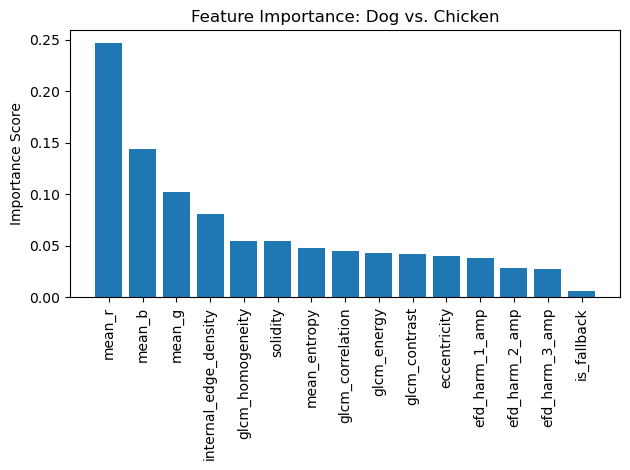

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get the importance of each feature
importances = model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

# 2. Plot the results
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.title("Feature Importance: Dog vs. Chicken")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()
plt.close()


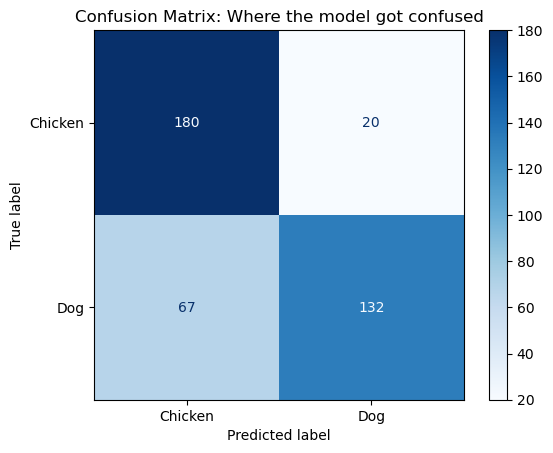

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Create the matrix comparing real labels (y_test) to guesses (y_pred)
cm = confusion_matrix(y_test, y_pred)

# 2. Display the grid
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Chicken', 'Dog'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Where the model got confused")
plt.show()
plt.close()

In [26]:
from sklearn.metrics import accuracy_score

# 1. Drop the 'mean' color columns to force the model to look at shape/textures
X_train_pruned = X_train.drop(columns=['mean_r', 'mean_g', 'mean_b'])
X_test_pruned = X_test.drop(columns=['mean_r', 'mean_g', 'mean_b'])

# 2. Re-train the model
model_pruned = RandomForestClassifier(n_estimators=100, random_state=42)
model_pruned.fit(X_train_pruned, y_train)

# 3. Test again
y_pred_pruned = model_pruned.predict(X_test_pruned)
print(f"New Accuracy (without color): {accuracy_score(y_test, y_pred_pruned) * 100:.2f}%")


New Accuracy (without color): 68.42%


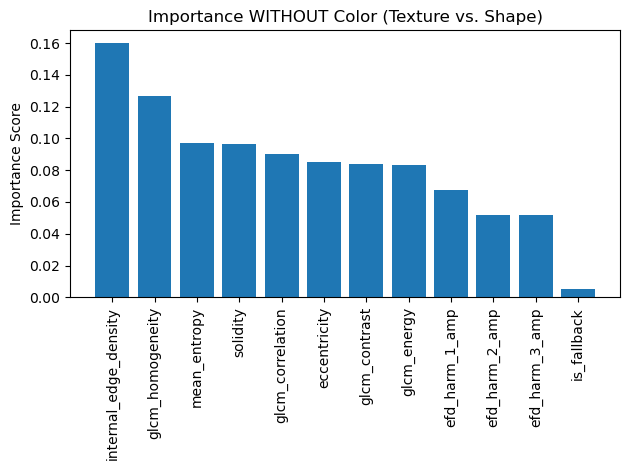

The new Top 3 'Pure Shape/Texture' traits are:
1. internal_edge_density
2. glcm_homogeneity
3. mean_entropy


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get the new importance from the pruned model
importances = model_pruned.feature_importances_
feature_names = X_train_pruned.columns
indices = np.argsort(importances)[::-1]

# 2. Plot the new "Texture & Shape" leaders
plt.bar(range(X_train_pruned.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_pruned.shape[1]), feature_names[indices], rotation=90)
plt.title("Importance WITHOUT Color (Texture vs. Shape)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

print("The new Top 3 'Pure Shape/Texture' traits are:")
for i in range(3):
    print(f"{i+1}. {feature_names[indices[i]]}")

In [32]:
# Group by the target and look at the average of your top 3 features
comparison = train_df.groupby('target')[['internal_edge_density', 'glcm_homogeneity', 'mean_entropy']].mean()

# Rename the index for clarity (0=Chicken, 1=Dog)
comparison.index = ['Chicken', 'Dog']
print("Average Trait Values by Class:")
print(comparison)

Average Trait Values by Class:
         internal_edge_density  glcm_homogeneity  mean_entropy
Chicken               0.078979          0.313232      4.708016
Dog                   0.058591          0.300973      4.639615
